<a href="https://colab.research.google.com/github/NuclearJuicer/Human-Chemokine-Ligand-19-via-AlphaFold-Assembly/blob/main/Human_Chemokine_Ligand_19%2C_via_AlphaFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

12:57:59 Starting prediction on 2022-07-20 UTC time
12:57:59 Installing ColabFold on Google Colab virtual machine.


Installing ColabFold
Installing Conda
Installing OpenMM


13:03:49 Query 1/1: af98 (length 98)
COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


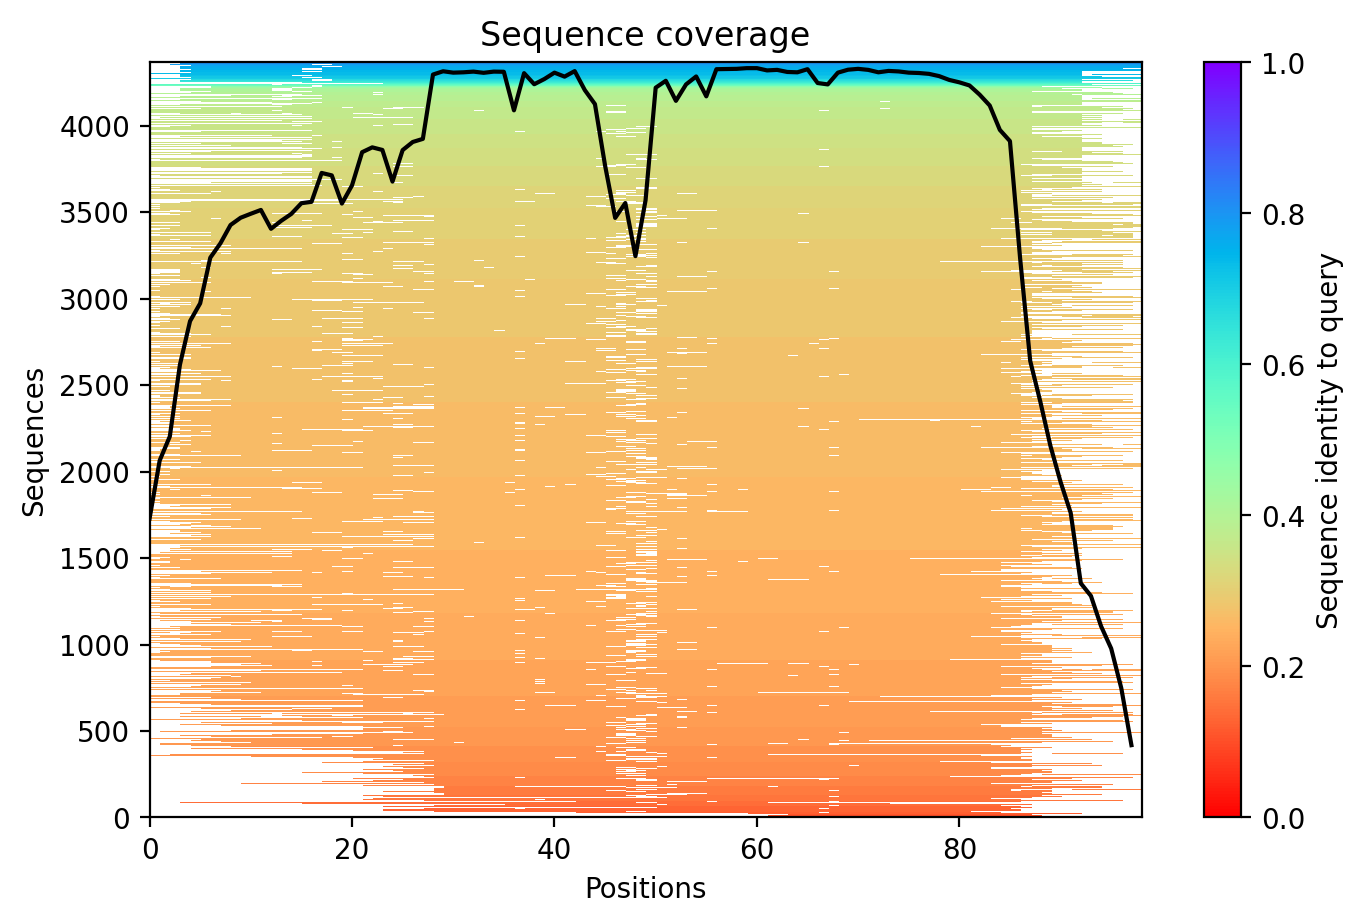

13:03:50 Running model_1
13:04:50 model_1 took 55.5s (3 recycles) with pLDDT 78.4 and ptmscore 0.605
13:05:47 Relaxation took 46.9s


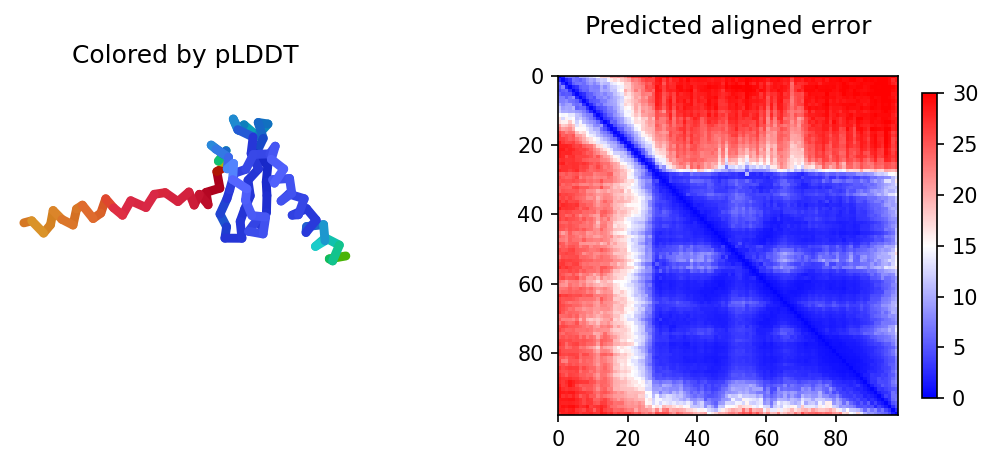

13:05:47 Running model_2
13:06:15 model_2 took 25.5s (3 recycles) with pLDDT 76.3 and ptmscore 0.599
13:06:59 Relaxation took 35.7s


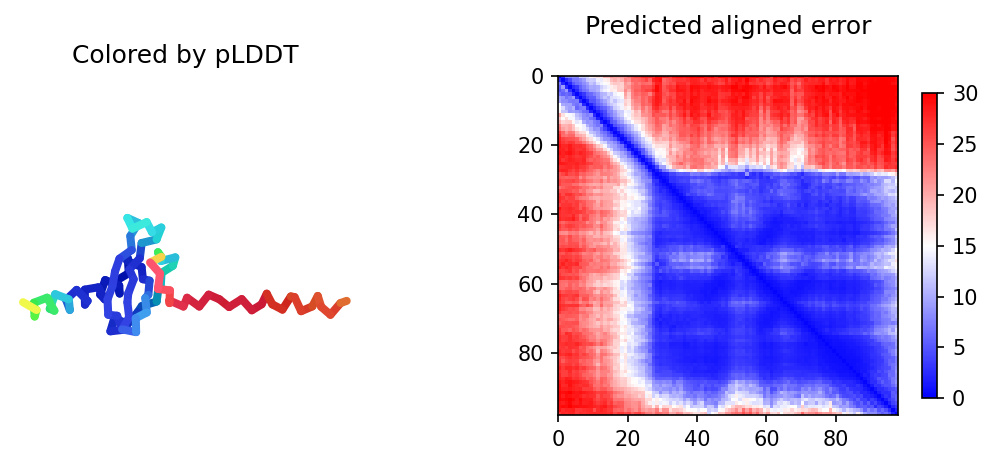

13:06:59 Running model_3
13:07:27 model_3 took 26.2s (3 recycles) with pLDDT 81.3 and ptmscore 0.639
13:08:14 Relaxation took 37.4s


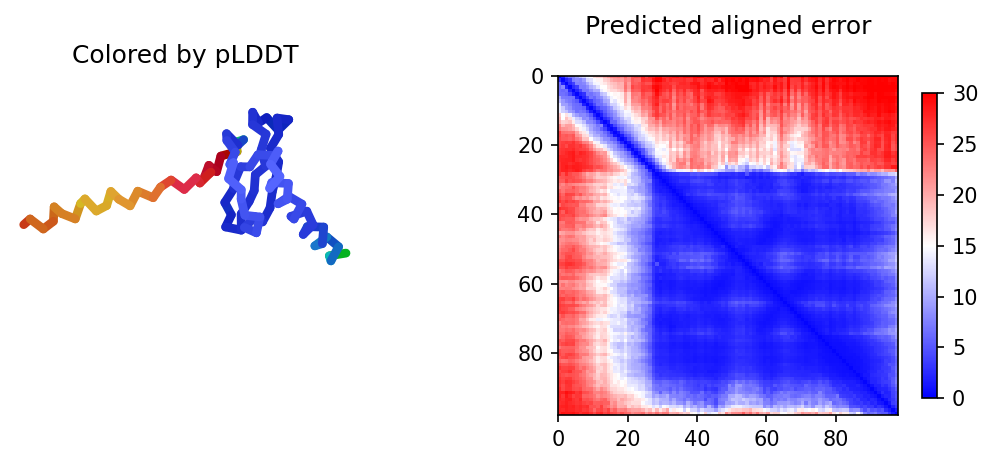

13:08:14 Running model_4
13:08:42 model_4 took 26.3s (3 recycles) with pLDDT 82.2 and ptmscore 0.645
13:09:32 Relaxation took 41.1s


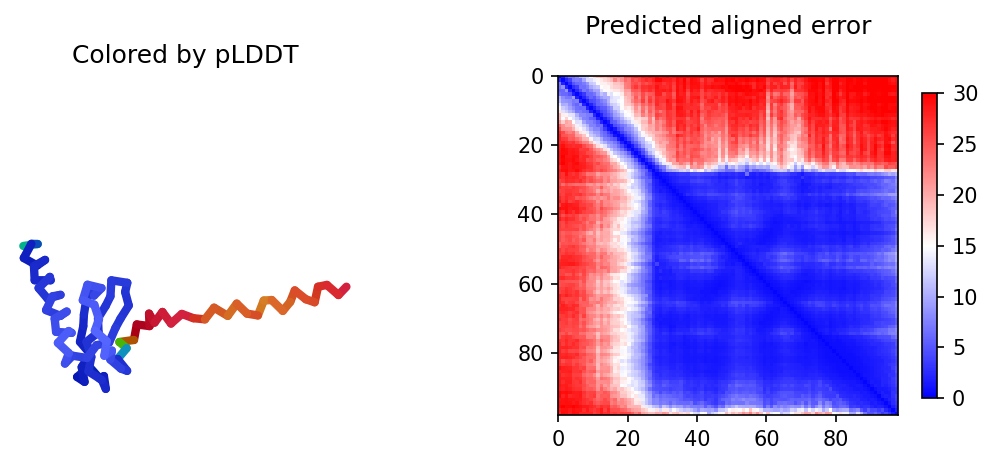

13:09:32 Running model_5
13:10:00 model_5 took 26.3s (3 recycles) with pLDDT 81.1 and ptmscore 0.657
13:10:46 Relaxation took 37.0s


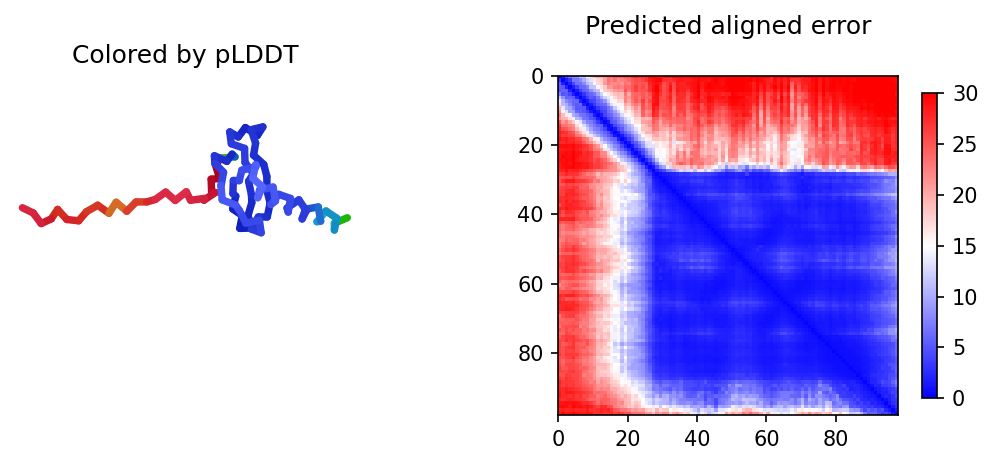

13:10:46 reranking models by plddt
13:10:48 Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================================================================================
# Google Colab code for running an AlphaFold structure prediction using ColabFold.
#
def run_prediction(sequences,
                   job_name = '',
                   msa_mode = "MMseqs2 (UniRef+Environmental)", 
                   pair_mode = "unpaired+paired",
                   use_templates = False,
                   custom_template_path = None,
                   energy_minimize = False,
                   model_type = "auto",
                   num_recycles = 3,
                   dpi = 200,
                   install_log = 'install_log.txt'):
    '''
    Installs alphafold if not yet installed and runs a stucture prediction.
    Model names ending in "_ptm" predict TM score ('model_1_ptm', ..., 'model_5_ptm').

    Parameters
    ----------
    msa_mode: "MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)", "single_sequence", "custom"
    pair_mode: "unpaired+paired", "paired", "unpaired"
       "unpaired+paired" = pair sequences from same species + unpaired MSA
       "unpaired" = seperate MSA for each chain
       "paired" - only use paired sequences.
    model_type: "auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"
       "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2"
        For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
    dpi: dots-per-inch for saved plot images
    '''

    start_logging()
    
    use_amber = energy_minimize
    
    install(use_amber=use_amber, use_templates=use_templates, install_log=install_log)

    warn_k80_gpu()

    remove_old_files()

    if not job_name:
        nres = sum(len(seq) for seq in sequences)
        job_name = 'af%d' % nres

    # Write sequences, used only for inclusion in returned results.
    with open('query.fasta', 'w') as seqs_file:
        seqs_file.write(''.join(f'>{i+1}\n{seq}\n' for i,seq in enumerate(sequences)))
                        
    from colabfold.utils import setup_logging
    from pathlib import Path
    setup_logging(Path(".").joinpath("log.txt"))
        
    query_sequence = ':'.join(sequences)
    queries_path=f"{job_name}.csv"
    with open(queries_path, "w") as text_file:
      text_file.write(f"id,sequence\n{job_name},{query_sequence}")

    from colabfold.batch import get_queries, set_model_type
    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, model_type)

    from colabfold.download import download_alphafold_params
    download_alphafold_params(model_type, Path("."))

    # Hack to plot the MSA coverage before making structure predictions.
    from colabfold import batch
    if not hasattr(batch, 'generate_input_feature_orig'):
      batch.generate_input_feature_orig = batch.generate_input_feature
      batch.generate_input_feature = generate_input_feature_wrapper
    
    from colabfold.batch import run
    run(
      queries=queries,
      result_dir='.',
      use_templates=use_templates,
      custom_template_path=custom_template_path,
      use_amber=use_amber,
      msa_mode=msa_mode,    
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      model_order=[1, 2, 3, 4, 5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      recompile_padding=1.0,
      rank_by="auto",
      pair_mode=pair_mode,
      stop_at_score=100.0,
      prediction_callback=prediction_callback(minimized_only=use_amber),
      dpi=dpi
    )

    print('Downloading structure predictions to directory Downloads/ChimeraX/AlphaFold')
    download_results(energy_minimize)

# ================================================================================================
#
def start_logging():
    msg = 'Please cite <a href="https://www.nature.com/articles/s41592-022-01488-1">ColabFold: Making protein folding accessible to all. Nature Methods (2022)</a> if you use these predictions.'
    from IPython.display import display, HTML
    display(HTML(msg))

    # Change logging to not show milliseconds
    import logging
    logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%-H:%M:%S')
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    import datetime
    logger.info('Starting prediction on %s UTC time'
                % datetime.datetime.utcnow().strftime('%Y-%m-%d'))

# ================================================================================================
#
def generate_input_feature_wrapper(*args, **kw):
  '''Hack to be able plot the MSA coverage before predicting structures.'''
  from colabfold import batch
  (input_features, domain_names) = batch.generate_input_feature_orig(*args, **kw)

  # Plot MSA coverage
  query_seqs_unique, query_seqs_cardinality = args[:2]
  query_sequence_len_array = [
    len(query_seqs_unique[i])
    for i, cardinality in enumerate(query_seqs_cardinality)
    for _ in range(0, cardinality)
  ]
  plot_msa(input_features, query_sequence_len_array)

  return (input_features, domain_names)
    
# ================================================================================================
#
def plot_msa(input_features, query_sequence_len_array, dpi=200):
  '''
  Copied from colabfold.batch run() routine, in order to show MSA coverage plot
  before structure predictions are made.
  '''
  na = input_features["num_alignments"]
  num_alignment = int(na) if na.ndim == 0 else na[0]  # Monomer pipeline has nres length array
  msa = input_features["msa"]
  query_sequence_len = sum(query_sequence_len_array)
  from colabfold.plot import plot_msa
  msa_plot = plot_msa(
          msa[0:num_alignment],
          msa[0],
          query_sequence_len_array,
          query_sequence_len,
          dpi=dpi,
      )
  msa_plot.show()
  msa_plot.close()

# ================================================================================================
#
class prediction_callback:
    def __init__(self, minimized_only = False):
        self._minimized_only = minimized_only
    def __call__(self, unrelaxed_protein, query_sequence_len_array,
                 prediction_result, input_features, type):
        if self._minimized_only and not type[1]:
            return  # Don't show unminimized.
        import matplotlib.pyplot as plt
        multimer = (len(query_sequence_len_array) > 1)
        nplots = 3 if multimer else 2
        fig, axes = plt.subplots(1,nplots,figsize=(9,3), dpi=150)
        plot_protein(unrelaxed_protein, axes[0], coloring = 'plddt')
        plot_pae(prediction_result["predicted_aligned_error"], axes[1], query_sequence_len_array)
        if multimer:
            plot_protein(unrelaxed_protein, axes[2], coloring = 'chain',
                         query_sequence_len_array=query_sequence_len_array)
        plt.show()
        plt.close()

# ================================================================================================
#
def plot_protein(protein, plot_axis, coloring='plddt', query_sequence_len_array = None,
                 best_view=True, line_w=2.0):
  '''
  Copied from colabfold.colabfold plot_protein() to allow combining with pae plot figure.
  '''
  import numpy as np
  pos = np.asarray(protein.atom_positions[:,1,:])
  plddt = np.asarray(protein.b_factors[:,0])

  # get best view
  if best_view:
    weights = plddt/100
    pos = pos - (pos * weights[:,None]).sum(0,keepdims=True) / weights.sum()
    from colabfold.colabfold import kabsch
    pos = pos @ kabsch(pos, pos, weights, return_v=True)
    
  xy_min = pos[...,:2].min() - line_w
  xy_max = pos[...,:2].max() + line_w
  plot_axis.set_xlim(xy_min, xy_max)
  plot_axis.set_ylim(xy_min, xy_max)
  plot_axis.axis(False)

  from colabfold.colabfold import plot_pseudo_3D
  if coloring == 'plddt':
    # color by pLDDT
    plot_pseudo_3D(pos, c=plddt, cmin=50, cmax=90, line_w=line_w, ax=plot_axis)
    plot_axis.set_title('Colored by pLDDT')
  elif coloring == 'chain':
    # color by chain
    c = np.concatenate([[n]*L for n,L in enumerate(query_sequence_len_array)])
    nchain = len(query_sequence_len_array)
    if nchain > 40:   plot_pseudo_3D(pos, c=c, line_w=line_w, ax=plot_axis)
    else:             plot_pseudo_3D(pos, c=c, cmap=chain_colormap(), cmin=0, cmax=39,
                                     line_w=line_w, ax=plot_axis)
    plot_axis.set_title('Colored by chain')
    
# ================================================================================================
#
def add_text(text, ax):
  return ax.text(0.5, 1.01, text, horizontalalignment='center',
                  verticalalignment='bottom', transform=ax.transAxes)
    
# ================================================================================================
#
def chain_colormap():
  pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
  import matplotlib.colors
  pymol_cmap = matplotlib.colors.ListedColormap(pymol_color_list)
  return pymol_cmap
    
# ================================================================================================
#
def plot_pae(pae, plot_axis, query_sequence_len_array, caption = 'Predicted aligned error'):
  # Code taken from colabfold.colabfold plot_paes() to allow specifying which plot
  plot_axis.set_title(f"{caption}", pad=20)
  Ln = pae.shape[0]
  image = plot_axis.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if len(query_sequence_len_array) > 1:
    plot_chain_names(query_sequence_len_array, plot_axis)
  import matplotlib.pyplot as plt
  plt.colorbar(mappable = image, ax = plot_axis, shrink = 0.9)

# ================================================================================================
#
def plot_chain_names(Ls, plot_axis):
  # Copied from colabfold.colabfold plot_ticks() to allow specifying the plot
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plot_axis.plot([0,Ln],[L,L],color="black")
    plot_axis.plot([L,L],[0,Ln],color="black")
  import numpy
  ticks = numpy.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  from string import ascii_uppercase,ascii_lowercase
  alphabet_list = list(ascii_uppercase+ascii_lowercase)
  plot_axis.set_yticks(ticks)
  plot_axis.set_yticklabels(alphabet_list[:len(ticks)])
    
# ================================================================================================
#
def download_results(energy_minimize):
  relax = 'relaxed' if energy_minimize else 'unrelaxed'
  !cp -p *_{relax}_rank_1_model_*.pdb best_model.pdb
  !cp -p *_unrelaxed_rank_1_model_*_scores.json best_model_pae.json

  # Make a zip file of the predictions
  !zip -q -r results.zip query.fasta *.csv *.json *.a3m *.pdb cite.bibtex *.png
    
  # Download predictions.
  from google.colab import files
  files.download('results.zip')
    
# ================================================================================================
#
def warn_k80_gpu():
  K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
  if "1" in K80_chk:
    print("WARNING: found GPU Tesla K80: limited to total length < 1000")
    if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
      import os
      del os.environ["TF_FORCE_UNIFIED_MEMORY"]
    if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
      import os
      del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

# ================================================================================================
#
def remove_old_files():
  '''
  Remove previous runs files otherwise they will not be overwritten because
  the file name contains both the rank number and model number.
  Also need to remove model_ and model_env directories otherwise errors
  occur if different sequences are run when computing MSA.
  '''
  !rm -rf *.pdb *.json *_ *_env

# ================================================================================================
#
def install(use_amber = False, use_templates = False, install_log = 'install_log.txt'):

  import logging
  logger = logging.getLogger(__name__)
  logger.info('Installing ColabFold on Google Colab virtual machine.')

  from os.path import exists
  if not exists('COLABFOLD_READY'):
    print ('Installing ColabFold')
    cmds = f'''
set -e
# We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
# high risk high gain
pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
touch COLABFOLD_READY
'''
    run_shell_commands(cmds, 'install_colabfold.sh', install_log)

  if (use_amber or use_templates) and not exists('CONDA_READY'):
    print('Installing Conda')
    cmds = f'''
# setup conda
set -e
wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
rm Miniconda3-latest-Linux-x86_64.sh
touch CONDA_READY
'''
    run_shell_commands(cmds, 'install_conda.sh', install_log)

  if use_templates and not exists('HH_READY'):
    print('Installing hhsuite')
    cmds = f'''  
# setup template search
set -e
conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
touch HH_READY
'''
    run_shell_commands(cmds, 'install_hhsuite.sh', install_log)

  if use_amber and not exists('AMBER_READY'):
    print('Installing OpenMM')
    cmds = f'''  
# setup openmm for amber refinement
set -e
conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
# Make colab python find conda openmm and pdbfixer
ln -s /usr/local/lib/python3.7/site-packages/simtk .
ln -s /usr/local/lib/python3.7/site-packages/pdbfixer .
touch AMBER_READY
'''
    run_shell_commands(cmds, 'install_openmm.sh', install_log)

  # Enable colabfold logging from batch module.
  from colabfold.batch import logger as colabfold_logger
  import logging
  colabfold_logger.setLevel(logging.INFO)
    
# ================================================================================================
#
def run_shell_commands(commands, filename, install_log):
  with open(filename, 'w') as f:
    f.write(commands)

  # The -x option logs each command with a prompt in front of it.
  !bash -x "{filename}" >> "{install_log}" 2>&1
  if _exit_code != 0:
    raise RuntimeError('Error running shell script %s, output in log file %s'
                       % (filename, install_log))

# ================================================================================================
#
def remove_from_list(list, item):
  '''Remove an item from a list. Return true if removed otherwise false.'''
  try:
    list.remove(item)
    return True
  except ValueError:
    return False
    
# ================================================================================================
# Predict a structure for a sequence.
#
sequences = 'MALLLALSLLVLWTSPAPTLSGTNDAEDCCLSVTQKPIPGYIVRNFHYLLIKDGCRVPAVVFTTLRGRQLCAPPDQPWVERIIQRLQRTSAKMKRRSS'  #@param {type:"string"}

# Remove options from list of sequences
seq_list = [seq.strip() for seq in sequences.split(',')]
dont_minimize = remove_from_list(seq_list, 'dont_minimize')		# Energy minimization
use_templates = remove_from_list(seq_list, 'use_pdb_templates')
remove_from_list(seq_list, 'prokaryote')  # Obsolete "prokaryote" flag

run_prediction(seq_list, use_templates = use_templates, energy_minimize = not dont_minimize)
